### Table of Contents

- [Load the data](#Load-the-data)
- [Extra functions for quick-n-dirty data exploration](#Extra-functions-for-quick-n-dirty-data-exploration)
- [Explore the data](#Explore-the-data)
- [Select the best features](#Select-the-best-features)
    - [$\chi^2$ and mutual info based feature selection](#$\chi^2$-and-mutual-info-based-feature-selection)
    - [Recursive Feature Elimination](#Recursive-Feature-Elimination)
    - [Feature Selection from Model](#Feature-Selection-from-Model)
    - [Particle Swarm Optimization for feature selection](#Particle-Swarm-Optimization-for-feature-selection)
    - [Best Features](#Best-Features)
- [Define the data prep func](#Define-the-data-prep-func)
    - [Verify the data prep routines](#Verify-the-data-prep-routines)

In [1]:
# common imports
from operator import itemgetter
import sqlite3
import pickle

# config and settings 
pd.options.display.max_columns = 80
pd.options.display.max_rows = 20

### Load the data

In [2]:
# load the train data set
with sqlite3.connect('lending-club-loan-data/train.sqlite') as db:
    df = pd.read_sql_query('SELECT * FROM loan', con=db)
    
df.set_index('id', inplace=True)    
df.index = df.index.astype(int)
df.shape

(621167, 73)

### Extra functions for quick-n-dirty data exploration

In [2]:
# func to explore the data values in a dataframe
def _edf(self): 
    """Explores the data values in df.
    
    Null values usually need to be imputed for maching learning algorithms.
    Also, the cardinality of the data may be reduced in many cases to speed up and improve learning.
    Hence, this func to explore the data values.
    
    Returns:
        df
    """

    df = self
    df = pd.concat([pd.DataFrame(np.round(100*df.isnull().sum()/len(df))).T, # the pct of null values
                    pd.DataFrame(df.isnull().sum()).T, # the num of null values
                    pd.DataFrame(df.apply(lambda s: len(s.unique()))).T, # the cardinality
                    pd.DataFrame(df.dtypes).T, # the dtypes
                    df.sample(3) # sample of 3 rows
                   ],ignore_index=True,
                 )
    df.index = ['pct_nulls','num_nulls', 'cardinality', 'dtype', 'row1', 'row2', 'row3'] 
    df = df[df.columns.sort_values()]
    
    return df


# attach the func to pd.DataFrame
pd.DataFrame.edf = _edf

In [4]:
df.edf()

,DEFAULT,acc_now_delinq,addr_state,all_util,annual_inc,annual_inc_joint,application_type,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,desc,dti,dti_joint,earliest_cr_line,emp_length,emp_title,funded_amnt,funded_amnt_inv,grade,home_ownership,il_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,max_bal_bc,member_id,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,next_pymnt_d,open_acc,open_acc_6m,open_il_12m,open_il_24m,open_il_6m,open_rv_12m,open_rv_24m,out_prncp,out_prncp_inv,policy_code,pub_rec,purpose,pymnt_plan,recoveries,revol_bal,revol_util,sub_grade,term,title,tot_coll_amt,tot_cur_bal,total_acc,total_bal_il,total_cu_tl,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code
pct_nulls,0,0,0,98,0,100,0,0,0,0,86,0,100,0,0,6,0,0,0,0,98,0,98,98,0,0,0,0,0,0,2,0,98,0,51,75,85,98,28,0,98,98,98,98,98,98,0,0,0,0,0,0,0,0,0,0,0,0,8,8,0,98,98,0,0,0,0,0,8,0,0,100,0
num_nulls,0,22,0,606287,3,620813,0,0,105,22,533090,0,620815,22,0,35893,0,0,0,0,608206,0,606287,606287,22,0,0,0,40,0,12281,0,606287,0,317726,465887,525303,606680,176698,22,606287,606287,606287,606287,606287,606287,0,0,0,22,0,0,0,0,357,0,0,113,49056,49056,22,606287,606287,0,0,0,0,0,49056,0,0,620813,0
cardinality,2,8,51,1083,38184,236,2,14648,10,28,87141,4062,315,689,12,222959,1371,7349,7,6,1199,2,18,27,25,61796,538,103,104,178840,99,1371,8832,621167,148,166,124,192,100,75,13,13,17,34,18,27,189976,203181,1,29,14,2,16234,66373,1301,35,2,46510,8732,273090,131,12247,33,381424,381823,266680,4686,201773,16465,621167,3,4,922
dtype,int64,float64,object,float64,float64,float64,object,float64,float64,float64,object,float64,float64,object,object,object,float64,float64,object,object,float64,object,float64,float64,float64,float64,object,object,object,float64,object,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object
row1,1,0,TX,NaN,105000,NaN,INDIVIDUAL,0,0,0,None,4.42,NaN,Oct-2003,7 years,Real Estate Agent,12000,12000,A,MORTGAGE,NaN,w,NaN,NaN,0,367.74,6.49%,Oct-2014,Dec-2015,367.74,May-2015,12000,NaN,3.37798e+07,NaN,NaN,NaN,NaN,None,5,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,credit_card,n,0,15094,93.2%,A2,36 months,Credit card refinancing,0,140275,11,NaN,NaN,2569.85,2569.85,415.26,0,2154.59,16200,https://www.lendingclub.com/browse/loanDetail....,Source Verified,None,751xx
row2,0,0,KY,NaN,49000,NaN,INDIVIDUAL,0,0,0,None,11.71,NaN,Sep-2004,4 years,School Psychologist,2000,2000,A,OWN,NaN,w,NaN,NaN,0,63.51,8.90%,Mar-2014,Jan-2016,63.51,Dec-2015,2000,NaN,1.50503e+07,NaN,NaN,NaN,NaN,Feb-2016,7,NaN,NaN,NaN,NaN,NaN,NaN,898.29,898.29,1,0,debt_consolidation,n,0,3817,23.1%,A5,36 months,Debt consolidation,1305,11949,19,NaN,NaN,1333.71,1333.71,232,0,1101.71,16500,https://www.lendingclub.com/browse/loanDetail....,Source Verified,None,418xx
row3,0,0,TX,NaN,85000,NaN,INDIVIDUAL,0,0,0,None,18.1,NaN,Aug-2004,5 years,supervisor,35000,35000,B,MORTGAGE,NaN,f,NaN,NaN,1,1137.43,10.49%,Jan-2015,Jan-2016,26803.2,Dec-2015,35000,NaN,4.19122e+07,NaN,NaN,NaN,NaN,None,14,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,debt_consolidation,n,0,24957,43.2%,B3,36 months,Debt consolidation,0,119236,34,NaN,NaN,38126.5,38126.5,3126.54,0,35000,57800,https://www.lendingclub.com/browse/loanDetail....,Verified,None,765xx


In [5]:
# func to explore source features, ie directly from the source
def fv(feature=None, agg=True):
    """Explores features from the data source
    
    Args:
        feature [str]: column name
        agg [bool]: whether to aggreagate the values with value_counts()
        
    Returns:
        s [pd.Series] or value_counts() result
    """
    
    with sqlite3.connect('lending-club-loan-data/train.sqlite') as db:
        if feature is None:
            # if no feature passed in, then return the list of all features to choose from
            ret_list = [ t[0] for t in db.execute("SELECT * FROM loan limit 1").description ]
            return ret_list
            
        # otherwise return the feature values
        res = db.execute('SELECT "{feature}" FROM loan'.format(feature=feature)).fetchall()
        s = pd.Series((t[0] for t in res))
        
    if agg: 
        return s.value_counts(dropna=False).sort_index() # returns the value_counts()
    else:
        return s # returns the raw values


In [6]:
fv("verification_status")

Not Verified       186804
Source Verified    230534
Verified           203829
dtype: int64

In [7]:
# func to explore the crosstab of feature values against the DEFAULT response
def ct(feature, norm_ct=True, ret_chi2p=False, df=df):
    """Show feature's cross tab against the DEFAULT response
    
    Args:
        feature (str): feature to analyze
        norm_ct (bool): whether to display the normalized features
        
    Returns:
        crosstab
        or
        p-value for the chi2 contingency test
    """
        
    with sqlite3.connect('lending-club-loan-data/train.sqlite') as db:
       
        # build df from sql    
        res = db.execute('SELECT "DEFAULT", {feature} FROM loan'.format(feature=feature)).fetchall()
        df = pd.DataFrame( ((t[0],t[1]) for t in res), columns=['DEFAULT',feature])
            
        if df[ df[feature].isnull() ].size > 0:
            # if there are nulls, then make 2 categories 'nulls', not-nulls'
            binning_method = "np.where(df['{feature}'].isnull(), 'null', 'not-null')"
            
        elif "O" == df[feature].dtype:
            # if feature is an Object
            binning_method = "df['{feature}']"
            
        elif "float" == df[feature].dtype:
            # if feature is numeric no nulls, then bin the values into buckets and assign the means to their values
            binning_method = ( "df.groupby( pd.cut(df['{feature}'], 4) )"
                               "['{feature}'].transform(lambda v: np.round(v.mean(),0))"
                             )
        else:
            # there are datetime, timeperiods, ...
            raise NotImplementedError("cross-tab for {dtype} NotImplemented").format(dtype=df[feature].dtype)

    # fill in the df and feature
    binning_method = binning_method.format(feature=feature)

    # build the crosstab of feature against DEFAULT
    ct = pd.crosstab( df.DEFAULT, 
                      eval(binning_method,globals(),locals()), 
                      rownames=['Loan Status'], 
                      colnames=[feature], 
                      dropna=False, 
                      normalize=norm_ct)

    # reorder the crosstab cells (1 means loan defaults)
    ct = ct.reindex([1,0])
        
    if ret_chi2p: # compute and return the chi2's p-value
        from scipy.stats import chi2_contingency
        return chi2_contingency(ct)[1] 
    else:        
        return ct # returns the crosstab


In [8]:
ct("verification_status")

verification_status,Not Verified,Source Verified,Verified
Loan Status,,,
1,0.017419,0.02126,0.027179
0,0.283312,0.34987,0.300959


### Explore the data

TODO list for data preparation:
- drop cols and rows that are highly unlikely to carry any predictive signal
- convert categorical (i.e. nominal, ordinal) types into numeric (i.e. int, floats)
- remove outliers
- impute missing values
- if cardinalities of categorical values seem unecesary large then bin and encode them 
- select the features with the highest potenial to carry the predictive signal

In [9]:
# keep checking the df while its features are being modified
df.edf()

,DEFAULT,acc_now_delinq,addr_state,all_util,annual_inc,annual_inc_joint,application_type,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,desc,dti,dti_joint,earliest_cr_line,emp_length,emp_title,funded_amnt,funded_amnt_inv,grade,home_ownership,il_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,max_bal_bc,member_id,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,next_pymnt_d,open_acc,open_acc_6m,open_il_12m,open_il_24m,open_il_6m,open_rv_12m,open_rv_24m,out_prncp,out_prncp_inv,policy_code,pub_rec,purpose,pymnt_plan,recoveries,revol_bal,revol_util,sub_grade,term,title,tot_coll_amt,tot_cur_bal,total_acc,total_bal_il,total_cu_tl,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code
pct_nulls,0,0,0,98,0,100,0,0,0,0,86,0,100,0,0,6,0,0,0,0,98,0,98,98,0,0,0,0,0,0,2,0,98,0,51,75,85,98,28,0,98,98,98,98,98,98,0,0,0,0,0,0,0,0,0,0,0,0,8,8,0,98,98,0,0,0,0,0,8,0,0,100,0
num_nulls,0,22,0,606287,3,620813,0,0,105,22,533090,0,620815,22,0,35893,0,0,0,0,608206,0,606287,606287,22,0,0,0,40,0,12281,0,606287,0,317726,465887,525303,606680,176698,22,606287,606287,606287,606287,606287,606287,0,0,0,22,0,0,0,0,357,0,0,113,49056,49056,22,606287,606287,0,0,0,0,0,49056,0,0,620813,0
cardinality,2,8,51,1083,38184,236,2,14648,10,28,87141,4062,315,689,12,222959,1371,7349,7,6,1199,2,18,27,25,61796,538,103,104,178840,99,1371,8832,621167,148,166,124,192,100,75,13,13,17,34,18,27,189976,203181,1,29,14,2,16234,66373,1301,35,2,46510,8732,273090,131,12247,33,381424,381823,266680,4686,201773,16465,621167,3,4,922
dtype,int64,float64,object,float64,float64,float64,object,float64,float64,float64,object,float64,float64,object,object,object,float64,float64,object,object,float64,object,float64,float64,float64,float64,object,object,object,float64,object,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object
row1,0,0,GA,NaN,95000,NaN,INDIVIDUAL,0,0,0,None,19.59,NaN,Dec-1999,8 years,Director of Operations,16000,16000,A,MORTGAGE,NaN,w,NaN,NaN,0,498.59,7.62%,Mar-2014,Jan-2016,15300,Jun-2014,16000,NaN,1.47886e+07,46,NaN,NaN,NaN,None,8,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,debt_consolidation,n,0,11853,66.6%,A3,36 months,Debt consolidation,0,241800,25,NaN,NaN,16297.2,16297.2,297.23,0,16000,17800,https://www.lendingclub.com/browse/loanDetail....,Source Verified,None,302xx
row2,0,0,PA,NaN,70000,NaN,INDIVIDUAL,0,0,1,None,12.99,NaN,Jul-1991,10+ years,Laboratory Supervisor,10000,9975,A,MORTGAGE,NaN,f,NaN,NaN,0,316.14,8.60%,Oct-2013,Jan-2016,316.14,Dec-2015,10000,NaN,1.00268e+07,16,35,NaN,NaN,Feb-2016,14,NaN,NaN,NaN,NaN,NaN,NaN,3040.43,3032.82,1,0,debt_consolidation,n,0,4223,34.3%,A4,36 months,loan,476,67599,24,NaN,NaN,8219.4,8198.85,1259.83,0,6959.57,12300,https://www.lendingclub.com/browse/loanDetail....,Source Verified,None,190xx
row3,0,0,TN,NaN,61000,NaN,INDIVIDUAL,0,0,0,Borrower added on 12/28/13 > consolidate hig...,12.91,NaN,Feb-2002,1 year,team driver,21000,21000,C,MORTGAGE,NaN,w,NaN,NaN,1,499.37,14.98%,Dec-2013,Jan-2016,499.37,Jan-2016,21000,NaN,1.19702e+07,NaN,NaN,110,NaN,Feb-2016,10,NaN,NaN,NaN,NaN,NaN,NaN,14410.2,14410.2,1,1,credit_card,n,0,11428,75.2%,C3,60 months,consolidate cc,0,17427,27,NaN,NaN,11983.2,11983.2,5393.42,0,6589.78,15200,https://www.lendingclub.com/browse/loanDetail....,Source Verified,None,376xx


In [10]:
# look like we've got to do some cleaning ...

In [11]:
# let's start off by dropping the features that do not seem to carry much of a predictive signal

cols_to_drop = [
    # these can be totally made up
    'desc', 'emp_title', 'purpose', 'title', 
    # !! investigate if they trully do not have any predictive power; try to stem, lem, tf-idf, T-SNE, etc
    
    # these ones are totally arbitrary
    'member_id', 'url', 

    # gonna keep sub_grade which is more specific than grade, so grade is dropped
    'grade',

    # gonna keep zip_codes which is more specific than addr_state
    'addr_state', # BTW: if the same zip code appears in two different states then that is incorrect 
                  # and the mapping state to zip_code should be investigated
    
    'mths_since_last_record', # 'The number of months since the last public record'
    
    'next_pymnt_d', # it is mostly null
    'last_pymnt_d', # ditto
]

df = df.drop(cols_to_drop, axis=1)

In [12]:
# next let's check the cols with more than 90% of nulls
f = df.edf()
very_sparse_cols = f.columns[ f.loc['pct_nulls'] > 90 ]
very_sparse_cols

Index(['all_util', 'annual_inc_joint', 'dti_joint', 'il_util', 'inq_fi',
       'inq_last_12m', 'max_bal_bc', 'mths_since_rcnt_il', 'open_acc_6m',
       'open_il_12m', 'open_il_24m', 'open_il_6m', 'open_rv_12m',
       'open_rv_24m', 'total_bal_il', 'total_cu_tl',
       'verification_status_joint'],
      dtype='object')

In [13]:
# the prob of DEFAULT
NoDefault, Default = fv("DEFAULT") / len(df)
NoDefault, Default # gives ca 93.3% of good loans, and 6.6% of bad loans

(0.9341417042437863, 0.06585829575621371)

In [14]:
# sometimes it seems that if a feature is null then it is more likely that the loan defaults
# e.g. for 'dti_joint', we got
ct('dti_joint')

dti_joint,not-null,null
Loan Status,,
1,0.000002,0.065857
0,0.000565,0.933577


In [15]:
# however, the prob of DEFAULT is only slightly higher
# ie DEFAULT given 'dti_joint' is null
Default_given_null_col, NoDefault_given_null_col =  ct('dti_joint')['null']
NoDefault_given_null_col, Default_given_null_col

(0.933576638810497, 0.0658566858831844)

In [16]:
# the increase in the prob of DEFAULT given 'dti_joint' is null
Default_given_null_col/(NoDefault_given_null_col + Default_given_null_col) - Default/(Default + NoDefault)

3.573064456591224e-05

In [17]:
# since the increase in prob is very small (less than ca 3.5e-3%), then for now, let's drop very_sparse_cols
df.drop(very_sparse_cols, axis=1, inplace=True)

In [18]:
df.edf()

,DEFAULT,acc_now_delinq,annual_inc,application_type,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,funded_amnt,funded_amnt_inv,home_ownership,initial_list_status,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_pymnt_amnt,loan_amnt,mths_since_last_delinq,mths_since_last_major_derog,open_acc,out_prncp,out_prncp_inv,policy_code,pub_rec,pymnt_plan,recoveries,revol_bal,revol_util,sub_grade,term,tot_coll_amt,tot_cur_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,verification_status,zip_code
pct_nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,75,0,0,0,0,0,0,0,0,0,0,0,8,8,0,0,0,0,0,0,8,0,0
num_nulls,0,22,3,0,0,105,22,0,22,0,0,0,0,0,22,0,0,0,40,0,0,317726,465887,22,0,0,0,22,0,0,0,357,0,0,49056,49056,22,0,0,0,0,0,49056,0,0
cardinality,2,8,38184,2,14648,10,28,4062,689,12,1371,7349,6,2,25,61796,538,103,104,178840,1371,148,166,75,189976,203181,1,29,2,16234,66373,1301,35,2,8732,273090,131,381424,381823,266680,4686,201773,16465,3,922
dtype,int64,float64,float64,object,float64,float64,float64,float64,object,object,float64,float64,object,object,float64,float64,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object
row1,0,0,90000,INDIVIDUAL,0,0,0,21.87,Nov-2008,1 year,15000,15000,RENT,w,0,539.06,17.57%,Sep-2015,Jan-2016,539.06,15000,NaN,NaN,15,13693.9,13693.9,1,0,n,0,12902,38.6%,D4,36 months,0,52059,27,2141.6,2141.6,835.52,0,1306.08,33400,Source Verified,774xx
row2,0,0,150000,INDIVIDUAL,0,0,1,11.69,Jun-1993,8 years,20000,20000,MORTGAGE,w,0,439.25,11.44%,Jan-2015,Jan-2016,439.25,20000,3,NaN,12,16855.5,16855.5,1,0,n,0,29614,52.9%,B4,60 months,0,249369,24,5258.29,5258.29,2113.8,0,3144.49,56000,Source Verified,029xx
row3,0,0,200000,INDIVIDUAL,0,0,1,6.11,Aug-1993,10+ years,30000,30000,RENT,w,0,942.59,8.18%,Oct-2015,Jan-2016,942.59,30000,15,NaN,13,27770.6,27770.6,1,0,n,0,16994,45.3%,B1,36 months,0,28756,31,2754.29,2754.29,524.9,0,2229.39,37500,Source Verified,900xx


In [19]:
# now, let's fix some data types

# first, convert date_cols to date types
date_cols = ['earliest_cr_line', 'issue_d', 'last_credit_pull_d']
df[date_cols] = df[date_cols].apply(lambda s: pd.to_datetime(s).dt.date)

# then, if earliest_cr_line is null then set it to issue_d
df['earliest_cr_line'].where( df['earliest_cr_line'].notnull(), df['issue_d'], inplace=True)

# convert some date types to timedeltas, since deltas are more likely to be meaningful than dates
event_cols = ['earliest_cr_line', 'last_credit_pull_d']
df[event_cols] = df[event_cols].apply(lambda s: (s - df.issue_d).dt.days )
df.earliest_cr_line *= -1 # change the sign, as earliest_cr_line is before issue_d

# drop issue_d
# NB: issue_d may play an important role with some macroeconomic data, but for now just lose it
df = df.drop('issue_d', axis=1) # and drop issue_d

In [20]:
# fillna and encode last_credit_pull_d
df.last_credit_pull_d = pd.cut( df.last_credit_pull_d , 9).factorize(sort=True)[0]
df[ df.last_credit_pull_d == -1] = 10 # na_sentinel=10 in factorize() doesn't work !? hence the hack

# fillna and encode mths_since_last_delinq
df.mths_since_last_delinq = pd.cut( df.mths_since_last_delinq , 9).factorize(sort=True)[0]
df[ df.mths_since_last_delinq == -1] = 10

# fillna and encode mths_since_last_major_derog
df.mths_since_last_major_derog = pd.cut( df.mths_since_last_major_derog , 9).factorize(sort=True)[0]
df[ df.mths_since_last_major_derog == -1] = 10

In [21]:
# convert interest rates in ir_cols to float
ir_cols = ['int_rate', 'revol_util']
df[ir_cols] = df[ir_cols].apply(lambda v: pd.to_numeric(v.str.rstrip('%'), errors='ignore'))

In [22]:
# fillna cols_to_fillna_with_0 with 0  
cols_to_fillna_with_0 = [
    'acc_now_delinq',
    'collection_recovery_fee',
    'collections_12_mths_ex_med',
    'delinq_2yrs',
    'inq_last_6mths',
    'pub_rec',
    'revol_util',
    'total_rev_hi_lim',
]
df[cols_to_fillna_with_0] = df[cols_to_fillna_with_0].fillna(0)

In [23]:
# fillna with 1
cols_to_fillna_with_1 = [
    'open_acc', 
    'total_acc'
]
df[cols_to_fillna_with_1] = df[cols_to_fillna_with_1].fillna(1)

In [24]:
# fillna 'annual_inc' with the mean for each installment group
# the reasoning being - the higher the installment the higher the annual_inc must had been
df.annual_inc = df.groupby( pd.cut( df.installment, 10) ).annual_inc.transform( lambda s: s.fillna( s.mean() ) )

In [25]:
# next, let's try 'collection_recovery_fee' 
fv('collection_recovery_fee') # it is mostly 0.0

0.0000       604895
0.0360            1
0.0711            1
0.1181            1
0.1348            1
0.1393            1
0.1400            1
0.1600            1
0.1800            2
0.1952            1
              ...  
4767.7900         1
4900.7500         1
4902.0800         1
5036.0100         1
5192.9900         1
5694.0936         1
5774.8000         1
6543.0400         1
6972.5900         1
7002.1900         1
Length: 14648, dtype: int64

In [26]:
ct('collection_recovery_fee') # but for higher 'collection_recovery_fee' the proba of default increases

collection_recovery_fee,5.0,2339.0,4086.0,6397.0
Loan Status,,,,
1,0.065736,0.00008,0.000034,0.000008
0,0.934142,0.00000,0.000000,0.000000


In [27]:
# so, let's binarize 'collection_recovery_fee' to 0 and 1 
df.collection_recovery_fee = np.where( df.collection_recovery_fee > 0, 1, 0)

In [28]:
# fillna some other features with some reasonable values 
df['tot_coll_amt'].fillna(df['loan_amnt'], inplace=True) # tot_coll_amt - 'Total collection amounts ever owed'
df['tot_cur_bal'].fillna(df['loan_amnt'], inplace=True)  # tot_cur_bal - 'Total current balance of all accounts'

# encoding zip_codes as 1's where DEFAULTs have occured and 0's (poor neighberhoods), otherwise
zip_code_with_defaults = df[df.DEFAULT == 1]['zip_code'].unique()
df['zip_code_with_defaults'] = np.where( df['zip_code'].isin( zip_code_with_defaults ), 1, 0)
df.drop('zip_code', axis=1, inplace=True)

In [29]:
df.edf()

,DEFAULT,acc_now_delinq,annual_inc,application_type,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,funded_amnt,funded_amnt_inv,home_ownership,initial_list_status,inq_last_6mths,installment,int_rate,last_credit_pull_d,last_pymnt_amnt,loan_amnt,mths_since_last_delinq,mths_since_last_major_derog,open_acc,out_prncp,out_prncp_inv,policy_code,pub_rec,pymnt_plan,recoveries,revol_bal,revol_util,sub_grade,term,tot_coll_amt,tot_cur_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,verification_status,zip_code_with_defaults
pct_nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
num_nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
cardinality,2,7,38185,2,2,9,27,4062,2666,12,1371,7349,6,2,24,61796,538,10,178840,1371,10,10,74,189976,203181,1,28,2,16234,66373,1300,35,2,9440,273117,130,381424,381823,266680,4686,201773,16464,3,2
dtype,int64,float64,float64,object,int64,float64,float64,float64,int64,object,float64,float64,object,object,float64,float64,float64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int64
row1,0,0,62500,INDIVIDUAL,0,0,2,15.19,5143,2 years,10550,10550,MORTGAGE,f,0,384.33,18.55,3,384.33,10550,1,0,22,9875.95,9875.95,1,1,n,0,5044,42,E2,36 months,0,153029,33,1142.12,1142.12,468.07,0,674.05,12000,Source Verified,1
row2,0,0,110000,INDIVIDUAL,0,0,0,15.63,5570,2 years,35000,35000,RENT,w,0,1154.66,11.53,3,1154.66,35000,0,0,7,33355.4,33355.4,1,0,n,0,49309,84.7,B5,36 months,0,58523,16,2398.99,2398.99,754.4,0,1644.59,58200,Verified,1
row3,0,0,22000,INDIVIDUAL,0,0,0,22.64,4383,10+ years,1800,1800,OWN,w,0,69.59,22.9,4,100,1800,0,0,7,636.31,636.31,1,0,n,0,12224,68.7,E4,36 months,0,12899,26,1752.62,1752.62,588.93,0,1163.69,17800,Not Verified,1


In [30]:
# encode some categoricals

# factorize factor_cols
factor_cols = [
    'application_type', 
    'initial_list_status', 
    'pymnt_plan', 
    'sub_grade', 
    'term'
]

for col in factor_cols:
    df[col] = df[col].astype('category').cat.as_ordered()
    df.insert( df.columns.get_loc(col), col+'_cd', df[col].cat.codes)
    # print out the category values for the reverse lookups 
    # later, df[new_col].cat.set_categories( df[cat_col].cat.categories, inplace=True );
    print('Cat Column:', col)
    print('Categories:', df[col].cat.categories)
    print( list(zip( np.arange(len( df[col].cat.categories )), df[col].cat.categories )) )
    print()
    df.drop(col, axis=1, inplace=True)
    

Cat Column: application_type
Categories: Index(['INDIVIDUAL', 'JOINT'], dtype='object')
[(0, 'INDIVIDUAL'), (1, 'JOINT')]

Cat Column: initial_list_status
Categories: Index(['f', 'w'], dtype='object')
[(0, 'f'), (1, 'w')]

Cat Column: pymnt_plan
Categories: Index(['n', 'y'], dtype='object')
[(0, 'n'), (1, 'y')]

Cat Column: sub_grade
Categories: Index(['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2',
       'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4',
       'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5'],
      dtype='object')
[(0, 'A1'), (1, 'A2'), (2, 'A3'), (3, 'A4'), (4, 'A5'), (5, 'B1'), (6, 'B2'), (7, 'B3'), (8, 'B4'), (9, 'B5'), (10, 'C1'), (11, 'C2'), (12, 'C3'), (13, 'C4'), (14, 'C5'), (15, 'D1'), (16, 'D2'), (17, 'D3'), (18, 'D4'), (19, 'D5'), (20, 'E1'), (21, 'E2'), (22, 'E3'), (23, 'E4'), (24, 'E5'), (25, 'F1'), (26, 'F2'), (27, 'F3'), (28, 'F4'), (29, 'F5'), (30, 'G1'), (31, 'G2'), (32, 'G3'), (33, 'G4'),

In [31]:
# encode emp_length    
def encode_emp_length(v):
    if v in (['1 year','2 years']):
        return 1
    elif v in (['3 year','4 years']):
        return 2
    elif v in (['5 year','6 years']):
        return 3
    elif v in (['7 year','8 years','9 year']):
        return 4            
    elif v in (['10 years', '10+ years']):
        return 5                           
    else:
        return 0
df['emp_length'] = df['emp_length'].apply(encode_emp_length)  

In [32]:
# factorize int_rate by rounding it
df.int_rate = 100*(df.int_rate/100).astype(int)    
    
    
# factorize dti
df['dti'] = pd.cut( df.dti, np.arange(0,1.1,.1).tolist() + [2,3,5,10,30,100] ).factorize(sort=True)[0]      


# factorize earliest_cr_line
df.earliest_cr_line = pd.qcut( df.earliest_cr_line , 9 ).factorize(sort=True)[0] 
df[ df.earliest_cr_line == -1] = 10 # na_sentinel=10 doesn't work !??

In [33]:
# let's get_dummies (one-hot-encoding) 

# for home_ownership
df = ( df.join ( pd.get_dummies( # convert cat values of home_ownership to dummies
                                 df.home_ownership.str.lower().replace({'none':'other'}), 
                                 prefix='home_ownship' 
                               )
               )
      
      .drop(  # drop now superfluous 'home_ownership'
              ['home_ownership'], axis=1 
              # 'ownership_other' can also be droped to remove multicollinearity
              # but multicollinearity does not reduce the predictive power or reliability of the model
              # it only causes erratic changes of coefficient estimates in regression models
              # for other models, such as GBM or DNN, it can be actually helpful
          )
     )

# for verification_status
df = ( df.join( pd.get_dummies( # convert cat values of verification_status to dummies
                                df.verification_status.str.lower().str.replace(r'\s+','_'),  
                                prefix='verif_stat' 
                              )
              )
      
      .drop(  # drop now superfluous 'verification_status' 
              ['verification_status'], axis=1 
              # 'verif_stat_not_verified' can also be droped to remove multicollinearity
              # but see the note for home_ownership above
          )
     )

# for verification_status_joint
# cardinality of verification_status_joint is 2, so for now do not bother
"""
df = ( df.join( pd.get_dummies( # convert cat values of verification_status_joint to dummies
                                df.verification_status_joint.str.lower().str.replace(r'\s+','_'),  
                                prefix='verif_stat_joint' 
                              )
              )
      
      .drop(  # drop now superfluous 'verification_status' 
              ['verification_status_joint'], axis=1 
              # 'verif_stat_joint_not_verified' can also be droped to remove multicollinearity
              # but see the note above
          )
     )
""";

In [34]:
# reduce the cardinality
cols_to_reduce_cardinality = [
    ('annual_inc', 1000),
    ('funded_amnt', 1000),
    ('funded_amnt_inv', 1000),
    ('installment', 100),
    ('last_pymnt_amnt', 100),
    ('loan_amnt', 100),
    ('out_prncp', 1000),
    ('out_prncp_inv', 1000),
    ('recoveries', 100),
    ('revol_bal', 100),
    ('revol_util', 10),
    ('total_acc', 10),
    ('tot_coll_amt', 1000),    
    ('tot_cur_bal', 1000),
    ('total_pymnt', 1000),
    ('total_pymnt_inv', 1000),
    ('total_rec_int', 1000),
    ('total_rec_late_fee', 10),
    ('total_rec_prncp', 1000),
    ('total_rev_hi_lim', 1000),
]
for col, divisor in cols_to_reduce_cardinality:
    df[col] = df[col].groupby( pd.cut( df[col], 100) ).transform( lambda v: divisor * np.round(v.mean()/divisor,0) )

In [35]:
# finally let's check our final df (should be no nulls, low cardinalities, and all numerics)
df.edf()

,DEFAULT,acc_now_delinq,annual_inc,application_type_cd,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,funded_amnt,funded_amnt_inv,home_ownship_any,home_ownship_mortgage,home_ownship_other,home_ownship_own,home_ownship_rent,initial_list_status_cd,inq_last_6mths,installment,int_rate,last_credit_pull_d,last_pymnt_amnt,loan_amnt,mths_since_last_delinq,mths_since_last_major_derog,open_acc,out_prncp,out_prncp_inv,policy_code,pub_rec,pymnt_plan_cd,recoveries,revol_bal,revol_util,sub_grade_cd,term_cd,tot_coll_amt,tot_cur_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,verif_stat_not_verified,verif_stat_source_verified,verif_stat_verified,zip_code_with_defaults
pct_nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
num_nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
cardinality,2,7,43,2,2,9,27,17,9,6,35,36,2,2,2,2,2,2,24,15,1,10,100,100,10,10,74,39,39,1,28,2,69,40,20,35,2,6,50,18,59,59,25,26,36,18,2,2,2,2
dtype,int64,float64,float64,int8,int64,float64,float64,int64,int64,int64,float64,float64,uint8,uint8,uint8,uint8,uint8,int8,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,int8,float64,float64,float64,int8,int8,float64,float64,float64,float64,float64,float64,float64,float64,float64,uint8,uint8,uint8,int64
row1,0,0,114000,0,0,0,0,15,6,5,6000,6000,0,1,0,0,0,0,0,200,0,3,200,6200,3,3,13,4000,4000,1,0,0,0,38200,80,1,0,1000,356000,20,3000,3000,0,0,2000,26000,1,0,0,1
row2,0,0,54000,0,0,0,0,15,8,5,25000,25000,0,0,0,0,1,1,0,700,0,4,500,25000,0,0,11,19000,19000,1,0,0,0,11500,80,18,1,1000,30000,20,13000,13000,7000,0,6000,26000,0,1,0,1
row3,0,0,54000,0,0,0,0,15,6,0,18000,18000,0,0,0,0,1,1,0,400,0,3,500,18000,0,0,10,17000,17000,1,0,0,0,11500,60,8,1,1000,30000,20,3000,3000,1000,0,2000,26000,0,1,0,1


In [36]:
# looks good, so let's move on

### Select the best features

In [37]:
# there are about 50 features left; let's check which ones are important for the predictive task
df.shape

(621167, 50)

#### Mutual-Info and $\chi^2$  based feature selection

In [38]:
# let's first try chi2 and mutual_info_classif (these are univariate relationships)
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, mutual_info_classif

In [39]:
y = df.iloc[:,0] # the DEFAULT col
X = df.iloc[:,1:] # the remaining cols

In [40]:
# estimate the mutual_info_classif between 'DEFAULT' (ie bad loan) and each individual col
feature_selector = SelectKBest(mutual_info_classif, k='all')
feature_selector.fit(X, y)

SelectKBest(k='all',
      score_func=<function mutual_info_classif at 0x7fa97a89a400>)

In [41]:
# sort the features
sorted_features = sorted( list(zip(X.columns, feature_selector.scores_)), key=itemgetter(1), reverse=True )

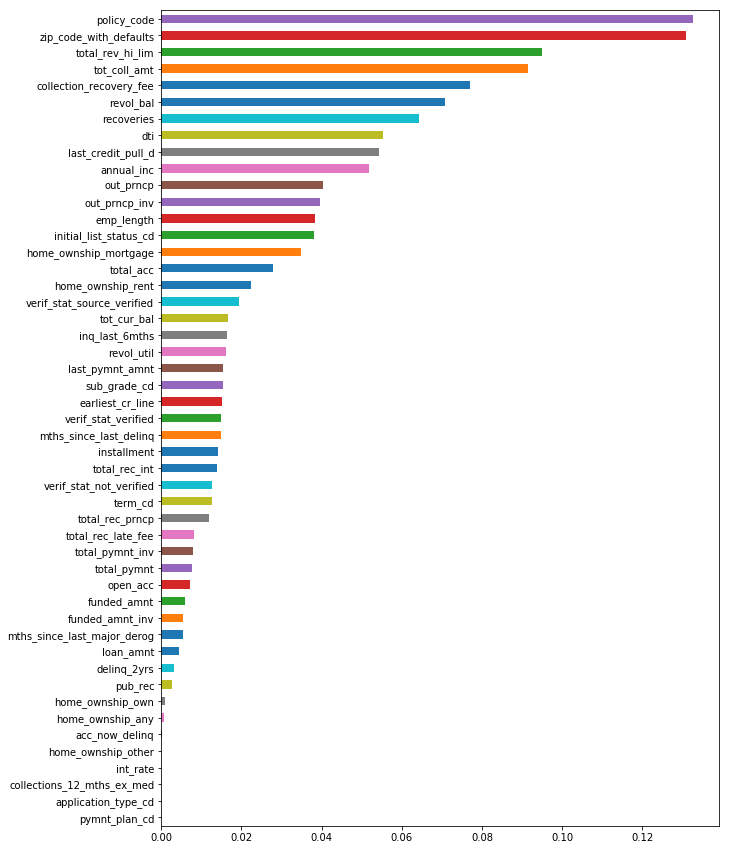

In [42]:
# display them
s = pd.Series( {k:v for k,v in sorted_features} ).sort_values()
plt.figure(figsize=(10,15))
s.plot.barh();

In [43]:
# since the above takes a while, pickle the best features_from_mutual_info_classif
with open( "features_from_mutual_info_classif.pkl", "wb" ) as fh:
    pickle.dump(sorted_features[:], fh )

In [44]:
# check if they can be loaded back
with open( "features_from_mutual_info_classif.pkl", "rb" ) as fh:
    best_features_from_mutual_info_classif = pickle.load(fh)

In [45]:
# select arbitrarily 25 best ones
fset_from_mutual_info_classif = {k for k,v in best_features_from_mutual_info_classif[:25]}

#### Feature Selection from Model

In [46]:
# estimate feature_importances_ using ensemble of trees
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

In [47]:
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)

In [48]:
sorted_features = sorted( list(zip(X.columns, clf.feature_importances_)), key=itemgetter(1), reverse=True )

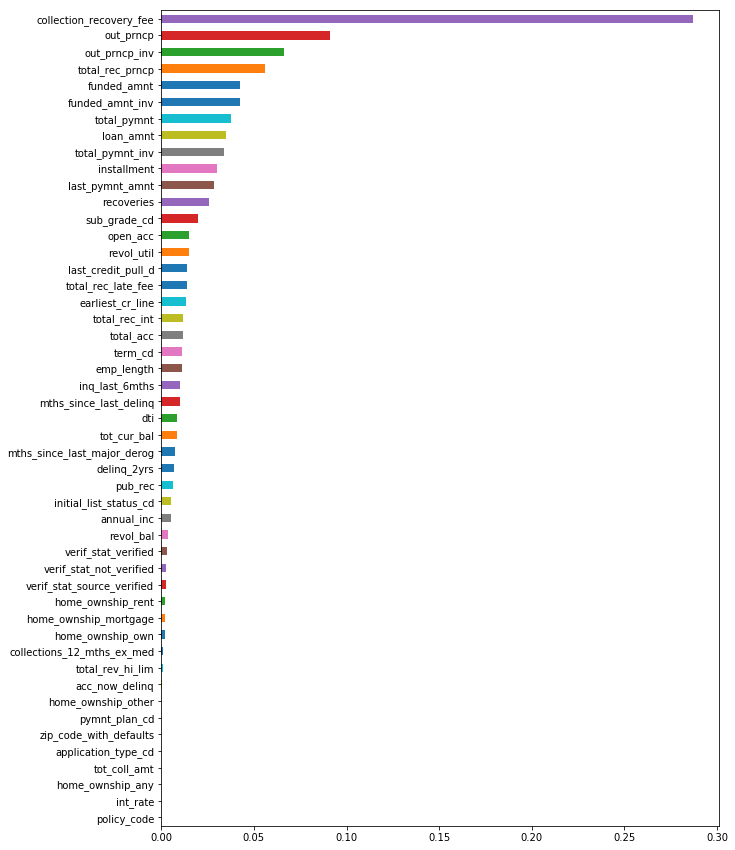

In [49]:
s = pd.Series( {k:v for k,v in sorted_features} ).sort_values()

plt.figure(figsize=(10,15))
s.plot.barh();

In [50]:
# pickle the best features_from_extra_trees_clf
with open( "features_from_extra_trees_clf.pkl", "wb" ) as fh:
    pickle.dump(sorted_features[:], fh )

In [51]:
# check if they can be loaded back
with open( "features_from_extra_trees_clf.pkl", "rb" ) as fh:
    best_features_from_extra_trees_clf = pickle.load(fh)

In [52]:
# select arbitrarily 25 best ones
fset_from_extra_trees_clf = {k for k,v in best_features_from_extra_trees_clf[:25]}

#### Recursive Feature Elimination

In [53]:
# RFECV
from sklearn.feature_selection import RFECV

In [54]:
# RFECV, or Recursive Feature Elimination, runs a cross-validation loop to find the optimal number of features
# it starts with the initial num of features, estimating coef_ or feature_importances_
# then it looses the least important ones, and repeats the process
# it is quite effective, but it takes time and time is a scarce resource
# TBD

#### Particle Swarm Optimization for feature selection

In [55]:
# estimate feature importances using PSO
import pyswarms as ps

#### Best Features

In [56]:
# combine the best feature sets and pickle them
combined_feature_set = fset_from_mutual_info_classif | fset_from_extra_trees_clf

with open( "best_predictive_features.pkl", "wb" ) as fh:
    pickle.dump( list(combined_feature_set), fh )

In [57]:
with open( "best_predictive_features.pkl", "rb" ) as fh:
        best_features = pickle.load( fh )
        
len(best_features)

37

In [58]:
sorted(best_features)

['annual_inc',
 'collection_recovery_fee',
 'dti',
 'earliest_cr_line',
 'emp_length',
 'funded_amnt',
 'funded_amnt_inv',
 'home_ownship_mortgage',
 'home_ownship_rent',
 'initial_list_status_cd',
 'inq_last_6mths',
 'installment',
 'last_credit_pull_d',
 'last_pymnt_amnt',
 'loan_amnt',
 'mths_since_last_delinq',
 'open_acc',
 'out_prncp',
 'out_prncp_inv',
 'policy_code',
 'recoveries',
 'revol_bal',
 'revol_util',
 'sub_grade_cd',
 'term_cd',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_acc',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_int',
 'total_rec_late_fee',
 'total_rec_prncp',
 'total_rev_hi_lim',
 'verif_stat_source_verified',
 'verif_stat_verified',
 'zip_code_with_defaults']

### Define the data prep func

In [59]:
# now let's create a file with code that can be imported and executed by other notebooks

In [60]:
%%writefile LC_data_prep.py
 
# this py module contains funcs related to the data from LendingClub 
# the data will be used to train our models in order to predict bad (ie defaulted) loans
# it contains:
#   - _execute_data_trans_workflow(df) 
#   - load_and_prep_data(load_test_data=False)
#   - load_raw_rows(load_test_data=False, raw_cols='loan_amnt, term, int_rate')
 
    
# common imports
import pickle
import sqlite3
import numpy as np
import pandas as pd
    

def _execute_data_trans_workflow(df):
    # what follows is just a copy from the data exploration phase
    # this is big and and calls for some refactoring
    # TODO: rewrite the data preparation workflow
    """
    This is a utility func to prep the LC data for model learning
    _execute_data_trans_workflow(df) is kinda messy and should be refactored
    """

    cols_to_drop = [
        'desc', 'emp_title', 'purpose', 'title', 
        'member_id', 'url', 
        'grade',
        'addr_state', 
        'mths_since_last_record', 
        'next_pymnt_d', 
        'last_pymnt_d',
    ]
    df = df.drop(cols_to_drop, axis=1)

    very_sparse_cols = [
           'all_util', 'annual_inc_joint', 'dti_joint', 'il_util', 'inq_fi',
           'inq_last_12m', 'max_bal_bc', 'mths_since_rcnt_il', 'open_acc_6m',
           'open_il_12m', 'open_il_24m', 'open_il_6m', 'open_rv_12m',
           'open_rv_24m', 'total_bal_il', 'total_cu_tl',
           'verification_status_joint']
    df.drop(very_sparse_cols, axis=1, inplace=True)

    date_cols = ['earliest_cr_line', 'issue_d', 'last_credit_pull_d']
    df[date_cols] = df[date_cols].apply(lambda s: pd.to_datetime(s).dt.date)

    df['earliest_cr_line'].where( df['earliest_cr_line'].notnull(), df['issue_d'], inplace=True)

    event_cols = ['earliest_cr_line', 'last_credit_pull_d']
    df[event_cols] = df[event_cols].apply(lambda s: (s - df.issue_d).dt.days )
    df.earliest_cr_line *= -1

    df = df.drop('issue_d', axis=1)

    df.last_credit_pull_d = pd.qcut( df.last_credit_pull_d , 9).factorize(sort=True)[0]
    df[ df.last_credit_pull_d == -1] = 10

    df.mths_since_last_delinq = pd.qcut( df.mths_since_last_delinq , 9).factorize(sort=True)[0]
    df[ df.mths_since_last_delinq == -1] = 10

    df.mths_since_last_major_derog = pd.qcut( df.mths_since_last_major_derog , 9).factorize(sort=True)[0]
    df[ df.mths_since_last_major_derog == -1] = 10

    ir_cols = ['int_rate', 'revol_util']
    df[ir_cols] = df[ir_cols].apply(lambda v: pd.to_numeric(v.str.rstrip('%'), errors='ignore'))  

    cols_to_fillna_with_0 = [
        'acc_now_delinq',
        'collection_recovery_fee',
        'collections_12_mths_ex_med',
        'delinq_2yrs',
        'inq_last_6mths',
        'pub_rec',
        'revol_util',
        'total_rev_hi_lim',
    ]
    df[cols_to_fillna_with_0] = df[cols_to_fillna_with_0].fillna(0)

    cols_to_fillna_with_1 = [
        'open_acc', 
        'total_acc'
    ]
    df[cols_to_fillna_with_1] = df[cols_to_fillna_with_1].fillna(1)

    df.annual_inc = df.groupby( pd.cut( df.installment, 10) ).annual_inc.transform( lambda s: s.fillna( s.mean() ) )

    df.collection_recovery_fee = np.where( df.collection_recovery_fee > 0, 1, 0)

    df['tot_coll_amt'].fillna(df['loan_amnt'], inplace=True) 
    df['tot_cur_bal'].fillna(df['loan_amnt'], inplace=True)  

    zip_code_with_defaults = df[df.DEFAULT == 1]['zip_code'].unique()
    df['zip_code_with_defaults'] = np.where( df['zip_code'].isin( zip_code_with_defaults ), 1, 0)
    df.drop('zip_code', axis=1, inplace=True)

    factor_cols = [
        'application_type', 
        'initial_list_status', 
        'pymnt_plan', 
        'sub_grade', 
        'term'
    ]
    for col in factor_cols:
        df[col] = df[col].astype('category').cat.as_ordered()
        df.insert( df.columns.get_loc(col), col+'_cd', df[col].cat.codes)
        df.drop(col, axis=1, inplace=True)

    def encode_emp_length(v):
        if v in (['1 year','2 years']):
            return 1
        elif v in (['3 year','4 years']):
            return 2
        elif v in (['5 year','6 years']):
            return 3
        elif v in (['7 year','8 years','9 year']):
            return 4            
        elif v in (['10 years', '10+ years']):
            return 5                           
        else:
            return 0
    df['emp_length'] = df['emp_length'].apply(encode_emp_length)  

    df.int_rate = (100*df.int_rate/100).astype(int)    

    df['dti'] = pd.cut(df.dti, np.arange(0,1.1,.1).tolist() + [2,3,5,10,30,100]).factorize(sort=True)[0]      

    df.earliest_cr_line = pd.qcut( df.earliest_cr_line , 9).factorize(sort=True)[0] 
    df[ df.earliest_cr_line == -1] = 10    

    df = ( df.join ( pd.get_dummies( 
                                     df.home_ownership.str.lower().replace({'none':'other'}), 
                                     prefix='home_ownship' 
                                   )
                   )

          .drop(  
                  ['home_ownership'], axis=1 
              )
         )


    df = ( df.join( pd.get_dummies( 
                                    df.verification_status.str.lower().str.replace(r'\s+','_'),  
                                    prefix='verif_stat' 
                                  )
                  )

          .drop(  
                  ['verification_status'], axis=1 
              )
         )

    cols_to_reduce_cardinality = [
        ('annual_inc', 1000),
        ('funded_amnt', 1000),
        ('funded_amnt_inv', 1000),
        ('installment', 100),
        ('last_pymnt_amnt', 100),
        ('loan_amnt', 100),
        ('out_prncp', 1000),
        ('out_prncp_inv', 1000),
        ('recoveries', 100),
        ('revol_bal', 100),
        ('revol_util', 10),
        ('tot_coll_amt', 1000),    
        ('tot_cur_bal', 1000),
        ('total_pymnt', 1000),
        ('total_pymnt_inv', 1000),
        ('total_rec_int', 1000),
        ('total_rec_late_fee', 10),
        ('total_rec_prncp', 1000),
        ('total_rev_hi_lim', 1000),
    ]
    for col, divisor in cols_to_reduce_cardinality:
        df[col] = df[col].groupby( pd.cut( df[col], 100) ).transform( lambda v: divisor * np.round(v.mean()/divisor,0) )

    return df



# this is for the data preparation workflow
def load_and_prep_data(load_test_data=False):
    """Loads the train or test data, then transforms them and returns a data frame.
    
    Args:
        load_test_data (bool): which data set, ie train or test, is to be loaded and prep'ed
    
    Returns:
        a df with the prepared data
    
    """
 
    if load_test_data:
        file_to_open = 'lending-club-loan-data/test.sqlite'
    else:
        file_to_open = 'lending-club-loan-data/train.sqlite'

    with sqlite3.connect(file_to_open) as db:
        df = pd.read_sql_query('SELECT * FROM loan', con=db)
    
    df.set_index("id",inplace=True)
    df.index = df.index.astype(int)
    
    df = _execute_data_trans_workflow(df)

    best_features = ["DEFAULT"]
    with open( "best_predictive_features.pkl", "rb" ) as fh:
        best_features += pickle.load( fh )
    
    df = df[ sorted(best_features) ]

    return df


# this is to extract the raw data, such as id, member_id, etc
def load_raw_rows(load_test_data=False, raw_cols='loan_amnt, term, int_rate'):
    """
    Loads the raw (as is) data
    
    Parameters
    ----------
    raw_cols : str defining the sql columns to use in SELECT
    
    Returns
    --------
    df : the data frame with the raw data
    """

    if load_test_data:
        file_to_open = 'lending-club-loan-data/test.sqlite'
    else:
        file_to_open = 'lending-club-loan-data/train.sqlite'

    with sqlite3.connect(file_to_open) as db:
        df = pd.read_sql_query('SELECT id, "DEFAULT", member_id, {raw_cols} FROM loan'.format(raw_cols=raw_cols), con=db)
        
    df.set_index("id",inplace=True)   
    
    df.index = df.index.astype(int)
    df.member_id = df.member_id.astype(int)
    
    if df.columns.contains('term'): df.term = np.where( df.term.str.contains('36'), 36, 60)
    if df.columns.contains('int_rate'): df.int_rate = df.int_rate.apply( lambda v: float(v.strip('%'))/100 )
    
    return df


Overwriting LC_data_prep.py


### Verify the data prep routines

##### **Start from here ** *(restart the kernel to verify that the data pipeline works correclty)*

In [3]:
# restart the kernel 
# run the imports at the top of the notebook too
# and the def edf()
# then continue
from LC_data_prep import load_and_prep_data

In [4]:
df = load_and_prep_data()
df.shape

(621167, 38)

In [5]:
# to hook up the edf() to df, run the edf()'s definition at the top of this notebook
df.edf()

,DEFAULT,annual_inc,collection_recovery_fee,dti,earliest_cr_line,emp_length,funded_amnt,funded_amnt_inv,home_ownship_mortgage,home_ownship_rent,initial_list_status_cd,inq_last_6mths,installment,last_credit_pull_d,last_pymnt_amnt,loan_amnt,mths_since_last_delinq,open_acc,out_prncp,out_prncp_inv,policy_code,recoveries,revol_bal,revol_util,sub_grade_cd,term_cd,tot_coll_amt,tot_cur_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,verif_stat_source_verified,verif_stat_verified,zip_code_with_defaults
pct_nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
num_nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
cardinality,2,43,2,17,9,6,35,36,2,2,2,24,15,10,100,100,10,74,39,39,1,69,40,20,35,2,6,50,130,59,59,25,26,36,18,2,2,2
dtype,int64,float64,int64,int64,int64,int64,float64,float64,uint8,uint8,int8,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int8,int8,float64,float64,float64,float64,float64,float64,float64,float64,float64,uint8,uint8,int64
row1,1,54000,1,15,7,0,23000,23000,0,1,0,0,800,9,200,23400,0,5,0,0,1,800,11500,40,9,0,1000,30000,10,16000,16000,5000,40,10000,26000,0,1,1
row2,0,54000,0,15,5,1,11000,11000,0,1,1,0,400,6,200,11000,0,4,0,0,1,0,11500,50,4,0,1000,30000,20,12000,12000,1000,0,11000,26000,0,0,1
row3,0,54000,0,11,3,0,18000,17000,0,0,0,1,600,9,11400,17600,0,8,0,0,1,0,11500,40,7,0,1000,30000,21,20000,20000,2000,0,17000,26000,0,1,1


##### [Next : 3a model development](Predicting-Loan-Defaults-3a-model-development.ipynb)